# K-Means Clustering (KMC) Implementation

#### In this notebook, I perform **unsupervised clustering** using the **K-means algorithm** on the top 40 most popular songs in the `songs.csv` dataset. The dataset, which comes from Spotify, contains various audio features extracted from songs, such as `danceability`, `energy`, and `key`. I focus on these three numerical features to group songs based on their musical characteristics — without using any genre or artist labels.

#### The goal is to use **K-means clustering** to group songs into similar-sounding clusters. I will try different values of **K (number of clusters)** to see which gives the best results, as well as evaluate this based on their inertia.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

## Import & Filter the Data

In [2]:
# Load CSV
df = pd.read_csv("songs.csv")

# Sort by track_popularity and select top 40
df_top = df.sort_values(by="track_popularity", ascending=False).head(40)

# Select relevant features
features = df_top[["danceability", "energy", "key"]]

# because k-means clustering is sensity to scale, I scale a bit more (though the data set already seems scaled enough)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

## KMC Algorithm

### First, i define all the functions necessary for making clusters, assigning points to them, updating these clusters, and compute the inertia.

In [3]:
def initialize_centroids(X, K):
    """Randomly initialize K centroids from the data points."""
    indices = np.random.choice(len(X), size=K, replace=False)
    return X[indices]

def assign_clusters(X, centroids):
    """Assign each point to the nearest centroid."""
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, K):
    """Update centroids as the mean of assigned points."""
    new_centroids = []
    for k in range(K):
        cluster_points = X[labels == k]
        if len(cluster_points) > 0:
            new_centroids.append(cluster_points.mean(axis=0))
        else:
            # In case a cluster gets no points, reinitialize its centroid
            new_centroids.append(X[np.random.choice(len(X))])
    return np.array(new_centroids)

def compute_inertia(X, centroids, labels):
    """Calculate total within-cluster sum of squares (inertia)."""
    inertia = 0
    for i, x in enumerate(X):
        center = centroids[labels[i]]
        inertia += np.sum((x - center) ** 2)
    return inertia

### KMeans Clustering implementation function

In [4]:
def kmeans(X, K, max_iters=100, tol=1e-4, verbose=False):
    """Full K-means clustering from scratch."""
    centroids = initialize_centroids(X, K)
    for i in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, K)

        # Check for convergence
        shift = np.linalg.norm(centroids - new_centroids)
        if verbose:
            print(f"Iteration {i}: centroid shift = {shift:.4f}")
        if shift < tol:
            break
        centroids = new_centroids

    inertia = compute_inertia(X, centroids, labels)
    return centroids, labels, inertia

## Result

Before running the kmeans clustering for various K to evaluate its performance, I run it here for K=5, meaning 5 clusters out of the 40 songs

In [5]:
centroids, labels, inertia = kmeans(X_scaled, K=5, max_iters=100, verbose=True)

# Add labels to your dataframe
df_top["Cluster"] = labels

Iteration 0: centroid shift = 1.7769
Iteration 1: centroid shift = 1.1413
Iteration 2: centroid shift = 0.4372
Iteration 3: centroid shift = 0.4057
Iteration 4: centroid shift = 0.5179
Iteration 5: centroid shift = 0.2505
Iteration 6: centroid shift = 0.0000


Above, you can see how the clustering process stops because centroid shift went to zero at iteration 6 (out of the possible maximum 100 iterations). In each iteration, clusters change as points are reassigned to the closest centroids, and then centroids are updated based on the new groups. This back-and-forth continues until the centroids stabilize and no longer move significantly, which happpened here at iter 6.



To evaluate whether these 5 clusters really seem to be their own type of song, I print out all 5 song clusters below.

In [6]:
# Show songs in all the clusters
for cluster_num in sorted(df_top["Cluster"].unique()):
    print(f"\n--- Songs in Cluster {cluster_num} ---")
    display(df_top[df_top["Cluster"] == cluster_num][["track_name", "track_artist", "Cluster"]])


--- Songs in Cluster 0 ---


,track_name,track_artist,Cluster
77,tusa,Karolg,0
428,life is good (feat. drake),Future,0
174,fantasias,Rauwalejandro,0
413,ayy macarena,Tyga,0
717,hola - remix,Dalex,0



--- Songs in Cluster 1 ---


,track_name,track_artist,Cluster
429,the box,Roddyricch,1
154,don't start now,Dualipa,1
21,ritmo (bad boys for life),Theblackeyedpeas,1
74,ride it,Regard,1
88,china,Anuelaa,1
432,bop,Dababy,1
163,south of the border (feat. camila cabello & ca...,Edsheeran,1
99,la canción,Jbalvin,1
119,adore you,Harrystyles,1
178,old town road - remix,Lilnasx,1



--- Songs in Cluster 2 ---


,track_name,track_artist,Cluster
96,blinding lights,Theweeknd,2
102,heartless,Theweeknd,2
98,bandit (with youngboy never broke again),Juicewrld,2
161,how do you sleep?,Samsmith,2
237,watermelon sugar,Harrystyles,2
109,before you go,Lewiscapaldi,2
881,all i want for christmas is you,Mariahcarey,2



--- Songs in Cluster 3 ---


,track_name,track_artist,Cluster
95,memories,Maroon5,3
388,falling,Trevordaniel,3
82,yummy,Justinbieber,3
52,bad guy,Billieeilish,3
155,highest in the room,Travisscott,3
211,my oh my (feat. dababy),Camilacabello,3
156,hot girl bummer,Blackbear,3
93,señorita,Shawnmendes,3
445,no idea,Dontoliver,3
32,lose control,Meduza,3



--- Songs in Cluster 4 ---


,track_name,track_artist,Cluster
79,everything i wanted,Billieeilish,4
97,someone you loved,Lewiscapaldi,4
107,lose you to love me,Selenagomez,4
164,lalala,Y2k,4
259,7 rings,Arianagrande,4


In [7]:
grouped = df_top.groupby("Cluster")[["track_name", "track_artist"]].agg(list)
display(grouped)

,track_name,track_artist
Cluster,,
0,"[tusa, life is good (feat. drake), fantasias, ...","[Karolg, Future, Rauwalejandro, Tyga, Dalex]"
1,"[the box, don't start now, ritmo (bad boys for...","[Roddyricch, Dualipa, Theblackeyedpeas, Regard..."
2,"[blinding lights, heartless, bandit (with youn...","[Theweeknd, Theweeknd, Juicewrld, Samsmith, Ha..."
3,"[memories, falling, yummy, bad guy, highest in...","[Maroon5, Trevordaniel, Justinbieber, Billieei..."
4,"[everything i wanted, someone you loved, lose ...","[Billieeilish, Lewiscapaldi, Selenagomez, Y2k,..."


### Interpretation

These clusters do indeed seem to have their own unique identities. 

Cluster 0 has 3 songs by latin artists, all of which employ elements of hip hop and rap, making the remaining two songs in the cluster (by American rap artists) a more natural fit. In fact, one of these two songs by American rap artists is a collaboration with a latin rapper, and it includes lyrics in Spanish.

Cluster 1 has a larger number of songs, 10. Most of the cluster is dominated by rap songs that employ pop elements, and there a a few (only 3 as far as I can tell) songs that are purely pop songs.

Cluster 2 appears very cohesive, with two songs by The Weekend and the rest being slightly softer pop songs, except for one rap.

Cluster 3 is the largest cluster. Out of 13 songs, 7 are pop, 5 are more rap, and 1 is more of an electronic dance song.

Lastly, Cluster 4, along with Cluster 1, is small but cohesive. All 5 songs in this cluster are pop-heavy, with 2 

## Analysis & Discussion

To analyze this implementation of KMC, I evaluate cluster quality using two methods:
- elbow method (using the measure of inertia we compute in kmeans function).
- silhouette score

Lastly, I visualize the clusters in 2D using PCA

#### Elbow Method

The elbow method helps determine the optimal number of clusters (K) by plotting the total within-cluster sum of squares (inertia) against different K values. As K increases, inertia decreases. This method is called the elbow method because there is a point in this graph when the curve begins to flatten (i.e., the inertia slows down more slowly)--this is the "elbow" point. The K associated with the "elbow" point is a good K to pick because it strikes a balance between low inertia and model simplicity.

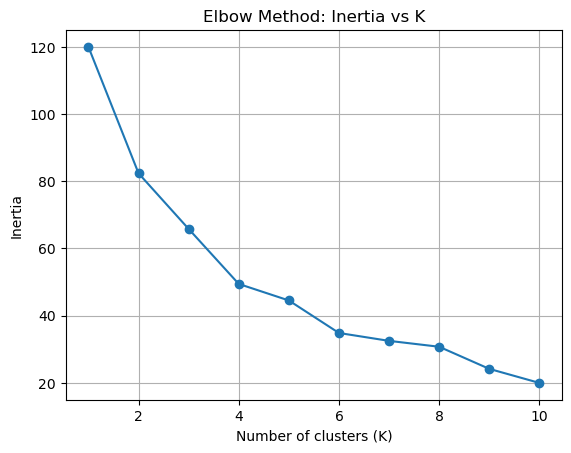

In [8]:
inertias = []
K_values = range(1, 11)

for K in K_values:
    _, _, inertia = kmeans(X_scaled, K, max_iters=100)
    inertias.append(inertia)

# Plot the elbow curve
import matplotlib.pyplot as plt

plt.plot(K_values, inertias, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method: Inertia vs K")
plt.grid(True)
plt.show()


As seen in the graph above, the elbow point is somewhere around K=4 or K=5, suggesting that a different choice of K earlier on, when we looked at the similarities in each of the 5 clusters, would not have been much beneficial.

#### Silhouette Score
The silhouette score measures how similar a point is to its own cluster compared to other clusters. Scores range from -1 to 1, with higher values indicating better-defined and more distinct clusters. This metric helps identify which K results in the most well-separated groups.



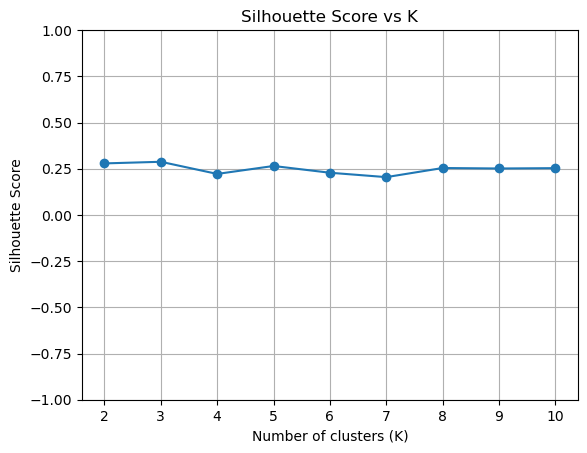

In [9]:
silhouette_scores = []
K_range = range(2, 11)

for K in K_range:
    _, labels, _ = kmeans(X_scaled, K, max_iters=100)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K")
plt.ylim(-1, 1)  # <- set y-axis range from 0 to 1
plt.grid(True)
plt.show()


Clearly, the silhouette scores for K ranging from 2 to 10 remained consistently low (~0.25), suggesting that the clustering structure in the selected feature space is weak or overlapping (in fact, the PCA visualization below shows some considerable overlap between clusters). This indicates that the chosen features—danceability, energy, and key—do not lead to strongly separated groups in the top 40 songs dataset, and this makes sense, as songs can have danceability and energy in vastly different ways though at the same level. While K-means still forms clusters, the model likely partitions a continuous space rather than revealing natural divisions. Perhaps a dataset of more stereotypical music from a few different genres will have natural divisions that could be predicted through other musical features. It is likely that popular songs are very similar in terms of their danceability, energy, and key, making it hard for the KMC algorithm to find any strong groupings.

#### PCA visualization

Principal Component Analysis (PCA) is used to reduce the dimensionality of the feature space to 2D so that clusters can be visualized. While the algorithm itself operates in higher dimensions, plotting the clusters in 2D helps assess how well-separated they are and whether the grouping appears meaningful.

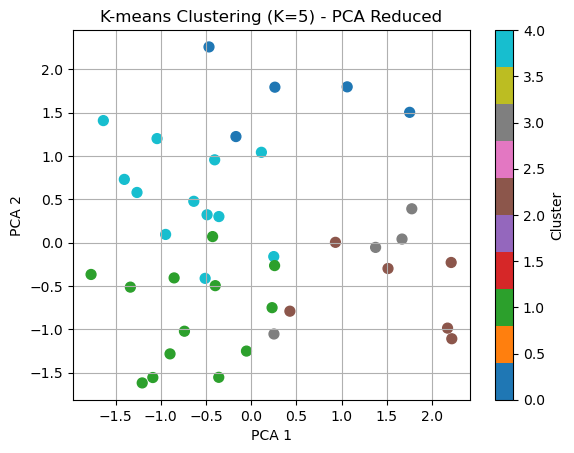

In [12]:
# Fit final model
K_final = 5
_, labels, _ = kmeans(X_scaled, K_final)

# Reduce to 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

# Plot clusters
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=50)
plt.title(f"K-means Clustering (K={K_final}) - PCA Reduced")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()

#### In summary, 
Based on the elbow method, a noticeable "elbow" appeared at K = 5, suggesting that 5 clusters offer a good tradeoff between inertia and model simplicity. The silhouette score did not disprove this choice, but it also did not support it, as the scores were very even across the board from K=2 to K=10.

The PCA visualization showed some fairly distinct groupings, with some overlap — suggesting that while the selected features (`danceability`, `energy`, `key`) provide some structure, they may not fully capture the differences between all songs. Still, many songs in the same cluster shared stylistic qualities that I was able to recognize from experience (not necessarily related to the three selected features), even though no genre information was used during clustering.

Overall, the clustering reveals meaningful groupings among the top 40 songs and an somewhat clear "elbow" point at K=5, but there were drawbacks that could be eliminated by adding more features (like tempo, genre, or lyrics).
